In [12]:
import os
os.environ['OPENAI_API_KEY'] = "EXAMPLE"

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Colab Notebooks/langchainsawman/week4

/content/drive/MyDrive/Colab Notebooks/langchainsawman/week4


# 인덱싱
##### 인덱싱 API를 사용하면 모든 소스의 문서를 벡터 저장소에 로드하고 동기화된 상태로 유지할 수 있다. 특히, 아래와 같은 상황에 도움이 된다.



*   벡터 저장소에 중복된 콘텐츠를 쓰지 마라
*   변경되지 않은 콘텐츠에 다시 작성하지 마라
*   변경되지 않은 콘텐츠에 대해 임베딩을 다시 계산하지 마라

##### 이 모든 기능을 통해 시간과 비용을 절약하고, 벡터 검색 결과도 향상할 수 있다
##### 결정적으로, 인덱싱 API는 원본 소스 문서와 관련하여 여러 변환 단계를 거친 문서에게도 작동한다.



## 작동 방식
##### Lanchain 인덱싱은 벡터 저장소에 기록된 문서를 추척하는 기록 관리자(RecordManager)를 사용한다.
##### 콘텐츠를 색인화할 때 각 문서에 대해 해시가 계산되고 다음 정보가 기록 관리자에 저장된다.




*  문서 해시(페이지 콘텐츠와 메타데이터)
*  쓰기 시간
*  소스 ID : 각 문서는 이 문서의 최종 소스를 결정할 수 있도록 메타데이터에 정보를 포함해야 한다.





## 삭제 모드
##### 문서를 벡터 저장소로 인덱싱할 때 벡터 저장소에 있는 일부 기존 문서를 삭제해야 할 수도 있다.
##### 특정 상황에서는 색인화되는 새 문서와 동일한 소스에서 파생된 기존 문서를 제거해야 할 수도 있다.
##### 다른 경우에는 기존 문서를 모두 삭제하고 싶을 수도 있다.
##### Indexing API 삭제 모드를 사용하면 원하는 동작을 선택할 수 있다.

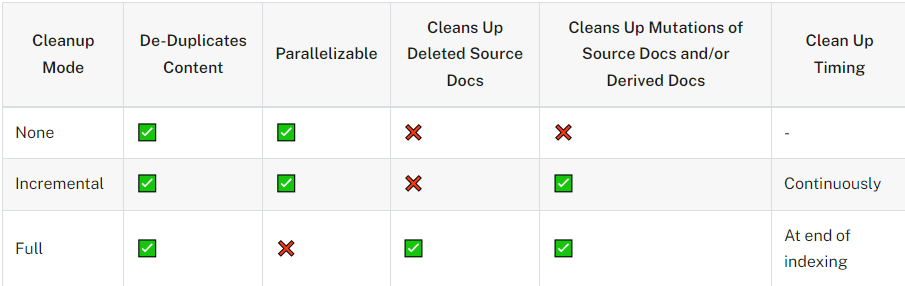

##### None : 자동 정리를 수행하지 않으므로 사용자가 오래된 콘텐츠를 수동으로 정리할 수 있다.
##### incremental/full 모두 자동 정리 기능 제공


*   소스 문서 또는 파생 문서의 콘텐츠가 변경된 경우 incremental/full 둘 다 이전 버전의 콘텐츠를 정리(삭제)한다.
*   소스 문서가 삭제된 경우 full 모드의 경우 해당 문서를 벡터 저장소에 삭제하지만 incremental은 삭제되지 않는다.


##### 정리 타이밍
*   incremental 모드의 경우 기록하는 동안 지속적으로 정리를 수행할 수 있으므로 정리 시간을 최소화할 수 있다.
*   full 모드는 모든 배치가 작성된 후 정리를 수행한다.





## 요구사항


1.   레코드 관리자는 레코드가 이전에 삽입되었는지 알 수 없으므로 인덱싱 API와 별도로 콘텐츠가 미리 채워지진 저장소와 함께 사용하지 마세요
2.   Langchain에서 지원하는 벡터 스토어만 사용 가능하다.

##### Compatible Vectorstores: AnalyticDB, AstraDB, AwaDB, Bagel, Cassandra, Chroma, CouchbaseVectorStore, DashVector, DatabricksVectorSearch, DeepLake, Dingo, ElasticVectorSearch, ElasticsearchStore, FAISS, HanaDB, Milvus, MyScale, OpenSearchVectorSearch, PGVector, Pinecone, Qdrant, Redis, Rockset, ScaNN, SupabaseVectorStore, SurrealDBStore, TimescaleVector, Vald, VDMS, Vearch, VespaStore, Weaviate, ZepVectorStore, TencentVectorDB, OpenSearchVectorSearch.

## 주의사항
##### 기록 관리자는 시간 기반 매커니즘을 사용하여 정리할 수 있는 콘텐츠를 결정한다.(정리 모드 - full or incremental)
##### 두 작업이 연속적으로 실행되고 특정 시간이 변경되기 전에 첫 번째 작업이 완료되면 두 번째 작업에서 콘텐츠를 정리하지 못할 수 있다.
##### 실제 상황에서는 크게 문제가 되지 않을 수 있다!

## 빠른 시작

In [ ]:
!pip install -q langchain

In [ ]:
!pip install -q langchain_elasticsearch

In [ ]:
!pip install -q langchain_openai

In [10]:
from langchain.indexes import SQLRecordManager, index
from langchain_core.documents import Document
from langchain_elasticsearch import ElasticsearchStore
from langchain_openai import OpenAIEmbeddings

In [ ]:
collection_name = "test_index"

embedding = OpenAIEmbeddings()

vectorstore = ElasticsearchStore(
    es_url="http://localhost:9200", index_name="test_index", embedding=embedding
)

In [ ]:
namespace = f"elasticsearch/{collection_name}"
record_manager = SQLRecordManager(
    namespace, db_url="sqlite:///record_manager_cache.sql"
)

In [ ]:
record_manager.create_schema()

##### 일부 테스트 문서를 색인화를 진행하자

In [ ]:
doc1 = Document(page_content="kitty", metadata={"source": "kitty.txt"})
doc2 = Document(page_content="doggy", metadata={"source": "doggy.txt"})

In [ ]:
def _clear():
    """Hacky helper method to clear content. See the `full` mode section to to understand why it works."""
    index([], record_manager, vectorstore, cleanup="full", source_id_key="source")

### None 삭제
##### 해당 모드는 이전 버전의 콘텐츠를 자동으로 정리하지 않는다. 그러나 여전히 콘텐츠 중복 제거는 처리된다.

In [ ]:
_clear()

In [ ]:
index(
    [doc1, doc1, doc1, doc1, doc1],
    record_manager,
    vectorstore,
    cleanup=None,
    source_id_key="source",
)

# output
# {'num_added': 1, 'num_updated': 0, 'num_skipped': 0, 'num_deleted': 0}

In [ ]:
_clear()

In [ ]:
index([doc1, doc2], record_manager, vectorstore, cleanup=None, source_id_key="source")

# output
# {'num_added': 2, 'num_updated': 0, 'num_skipped': 0, 'num_deleted': 0}

##### 두 번째로 모든 콘텐츠를 건너 뛴다.

In [ ]:
_clear()

In [ ]:
index([doc1, doc2], record_manager, vectorstore, cleanup=None, source_id_key="source")

# output
# {'num_added': 0, 'num_updated': 0, 'num_skipped': 2, 'num_deleted': 0}

### incremental 삭제

In [ ]:
_clear()

In [ ]:
index(
    [doc1, doc2],
    record_manager,
    vectorstore,
    cleanup="incremental",
    source_id_key="source",
)

# output
# {'num_added': 2, 'num_updated': 0, 'num_skipped': 0, 'num_deleted': 0}

##### 다시 인덱싱하면 두 문서가 모두 건너뛰고, 삽입 작입도 건너뛴다.

In [ ]:
index(
    [doc1, doc2],
    record_manager,
    vectorstore,
    cleanup="incremental",
    source_id_key="source",
)

# output
# {'num_added': 0, 'num_updated': 0, 'num_skipped': 2, 'num_deleted': 0}

##### 중복 인덱싱 모드로 문서를 제공하지 않으면 아무 것도 변경되지 않는다.

In [ ]:
index([], record_manager, vectorstore, cleanup="incremental", source_id_key="source")

# output
# {'num_added': 0, 'num_updated': 0, 'num_skipped': 0, 'num_deleted': 0}

##### 문서를 변경하면 새 버전이 작성되고 동일한 소스를 공유하는 모든 이전 버전이 삭제된다.

In [ ]:
changed_doc_2 = Document(page_content="puppy", metadata={"source": "doggy.txt"})

In [ ]:
index(
    [changed_doc_2],
    record_manager,
    vectorstore,
    cleanup="incremental",
    source_id_key="source",
)

# output
# {'num_added': 1, 'num_updated': 0, 'num_skipped': 0, 'num_deleted': 1}

### full 삭제
##### full 모드의 경우 인덱싱되어야 하는 콘텐츠를 전달해야 한다. 그렇지 않으면 벡터 저장소에 있는 모든 문서는 삭제된다.
##### 해당 동작은 소스 문서 삭제를 처리하는데 유용하다.

In [ ]:
_clear()

In [ ]:
all_docs = [doc1, doc2]

In [ ]:
index(all_docs, record_manager, vectorstore, cleanup="full", source_id_key="source")

# output
# {'num_added': 2, 'num_updated': 0, 'num_skipped': 0, 'num_deleted': 0}

##### 누군가 첫 번째 문서를 삭제했다고 가정해보자

In [ ]:
del all_docs[0]

In [ ]:
all_docs

# output
# [Document(page_content='doggy', metadata={'source': 'doggy.txt'})]

##### full 모드의 경우 삭제된 콘텐츠도 정리된다.

In [ ]:
index(all_docs, record_manager, vectorstore, cleanup="full", source_id_key="source")

# output
# {'num_added': 0, 'num_updated': 0, 'num_skipped': 1, 'num_deleted': 1}

## 출처(source)
##### 메타데이터 속성에는 source라는 필드가 포함되어 있다. 이 source는 해당 문서와 관련된 최종 출처를 가르켜야 한다.

In [14]:
from langchain_text_splitters import CharacterTextSplitter

In [15]:
doc1 = Document(
    page_content="kitty kitty kitty kitty kitty", metadata={"source": "kitty.txt"}
)
doc2 = Document(page_content="doggy doggy the doggy", metadata={"source": "doggy.txt"})

In [16]:
new_docs = CharacterTextSplitter(
    separator="t", keep_separator=True, chunk_size=12, chunk_overlap=2
).split_documents([doc1, doc2])
new_docs

[Document(page_content='kitty kit', metadata={'source': 'kitty.txt'}),
 Document(page_content='tty kitty ki', metadata={'source': 'kitty.txt'}),
 Document(page_content='tty kitty', metadata={'source': 'kitty.txt'}),
 Document(page_content='doggy doggy', metadata={'source': 'doggy.txt'}),
 Document(page_content='the doggy', metadata={'source': 'doggy.txt'})]

In [ ]:
_clear()

In [ ]:
index(
    new_docs,
    record_manager,
    vectorstore,
    cleanup="incremental",
    source_id_key="source",
)

# output
# {'num_added': 5, 'num_updated': 0, 'num_skipped': 0, 'num_deleted': 0}

In [ ]:
changed_doggy_docs = [
    Document(page_content="woof woof", metadata={"source": "doggy.txt"}),
    Document(page_content="woof woof woof", metadata={"source": "doggy.txt"}),
]

##### 이렇게 하면 source와 관련된 이전 버전의 문서가 삭제되고 doggy.txt는 새 버전으로 대체된다.

In [ ]:
index(
    changed_doggy_docs,
    record_manager,
    vectorstore,
    cleanup="incremental",
    source_id_key="source",
)

# output
# {'num_added': 2, 'num_updated': 0, 'num_skipped': 0, 'num_deleted': 2}

In [ ]:
vectorstore.similarity_search("dog", k=30)

# output
# [Document(page_content='woof woof', metadata={'source': 'doggy.txt'}),
# Document(page_content='woof woof woof', metadata={'source': 'doggy.txt'}),
# Document(page_content='tty kitty', metadata={'source': 'kitty.txt'}),
# Document(page_content='tty kitty ki', metadata={'source': 'kitty.txt'}),
# Document(page_content='kitty kit', metadata={'source': 'kitty.txt'})]

## 로더와 함께 사용
##### 인덱싱은 반복 가능한 문서나 다른 로더를 허용할 수 있다.
##### 주의하자면 로더는 source 키를 올바르게 설정해야 한다!

In [ ]:
from langchain_community.document_loaders.base import BaseLoader


class MyCustomLoader(BaseLoader):
    def lazy_load(self):
        text_splitter = CharacterTextSplitter(
            separator="t", keep_separator=True, chunk_size=12, chunk_overlap=2
        )
        docs = [
            Document(page_content="woof woof", metadata={"source": "doggy.txt"}),
            Document(page_content="woof woof woof", metadata={"source": "doggy.txt"}),
        ]
        yield from text_splitter.split_documents(docs)

    def load(self):
        return list(self.lazy_load())

In [ ]:
_clear()

In [ ]:
loader = MyCustomLoader()

In [ ]:
loader.load()

# output
# [Document(page_content='woof woof', metadata={'source': 'doggy.txt'}),
# Document(page_content='woof woof woof', metadata={'source': 'doggy.txt'})]

In [ ]:
index(loader, record_manager, vectorstore, cleanup="full", source_id_key="source")

# output
# {'num_added': 2, 'num_updated': 0, 'num_skipped': 0, 'num_deleted': 0}

In [ ]:
vectorstore.similarity_search("dog", k=30)

# output
# [Document(page_content='woof woof', metadata={'source': 'doggy.txt'}),
# Document(page_content='woof woof woof', metadata={'source': 'doggy.txt'})]